## This Script compares different expansion parameter choices for the stardist segmentation

Please select the tmp_xenium_publication_env to run this script

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from shapely.geometry import Polygon
from skimage.io import imread as skimread
from shapely import wkt
from companion_functions import (
    plot_polygons
)

In [2]:
polygons_enact_0 = '/srv/gstore/projects/p37785/EzPyzENACTApp_2025-07-04--15-13-09/ENACTApp_Visium_HD_Human_Lung_Cancer_post_Xenium_5K_Experiment2/nuclei_df.csv'
polygons_enact_1 = '/srv/gstore/projects/p37785/EzPyzENACTApp_2025-06-29--22-46-24/ENACTApp_Visium_HD_Human_Lung_Cancer_post_Xenium_5K_Experiment2/cells_df.csv'
polygons_enact_2 = '/srv/gstore/projects/p37785/EzPyzENACTApp_2025-06-29--17-57-49/ENACTApp_Visium_HD_Human_Lung_Cancer_post_Xenium_5K_Experiment2/cells_df.csv'
polygons_enact_3 = '/srv/gstore/projects/p37785/EzPyzENACTApp_2025-06-29--22-47-07/ENACTApp_Visium_HD_Human_Lung_Cancer_post_Xenium_5K_Experiment2/cells_df.csv'

wsi_image_path = '/srv/gstore/projects/p37785/EzPyzENACTApp_2025-06-29--17-57-49/ENACTApp_Visium_HD_Human_Lung_Cancer_post_Xenium_5K_Experiment2/tmap/wsi.tif'

In [3]:

# Load the Visium full resolution image
wsi_image = skimread(wsi_image_path)


In [4]:
# Filter polygons to those that overlap the zoomed region
def polygon_in_crop(polygon, x_min, x_max, y_min, y_max):
    # polygon: (N,) array of interleaved x and y coordinates
    xs = polygon[::2]  # x coordinates are at even indices
    ys = polygon[1::2] # y coordinates are at odd indices
    return (
        (xs >= x_min).any() and (xs < x_max).any() and
        (ys >= y_min).any() and (ys < y_max).any()
    )

# Shift polygons so they match the crop region
def shift_polygon(polygon, x_min, y_min):
    shifted_polygon = polygon.copy()
    shifted_polygon[::2] -= x_min  # Subtract x_min from x coordinates
    shifted_polygon[1::2] -= y_min # Subtract y_min from y coordinates
    return shifted_polygon

In [5]:
csv_paths = [polygons_enact_0, polygons_enact_1, polygons_enact_2, polygons_enact_3]  # Add more paths as needed

cell_polygons = {}
for idx, path in enumerate(csv_paths):
    df = pd.read_csv(path)
    df = df.dropna(subset=['geometry'])
    df["parsed_geometry"] = df["geometry"].apply(wkt.loads)
    df["parsed_coordinates"] = df["parsed_geometry"].apply(
        lambda geom: np.array(geom.exterior.coords).flatten()
    )
    polygons = df["parsed_coordinates"].to_numpy()
    centers = np.array([np.mean(poly.reshape(-1, 2), axis=0) for poly in polygons])
    cell_polygons[idx] = {
        "polygons": polygons,
        "centers": centers
    }


In [6]:
crop_size = 1000
x_min, y_min = 2000, 2000  # Starting coordinates for the crop
x_max,y_max = x_min + crop_size, y_min + crop_size  # Ending coordinates for the crop

In [7]:
crop_polygons_demean = {}
for idx, data in cell_polygons.items():
    polygons = data["polygons"]
    centers = data["centers"]
    
    # Filter polygons that are within the crop region
    crop_polygons_demean[idx] = {'polygons_dem':[
        shift_polygon(poly, *center).reshape(-1, 2)
        for poly, center in zip(polygons, centers)
        if polygon_in_crop(poly, x_min, x_max, y_min, y_max)
    ]}


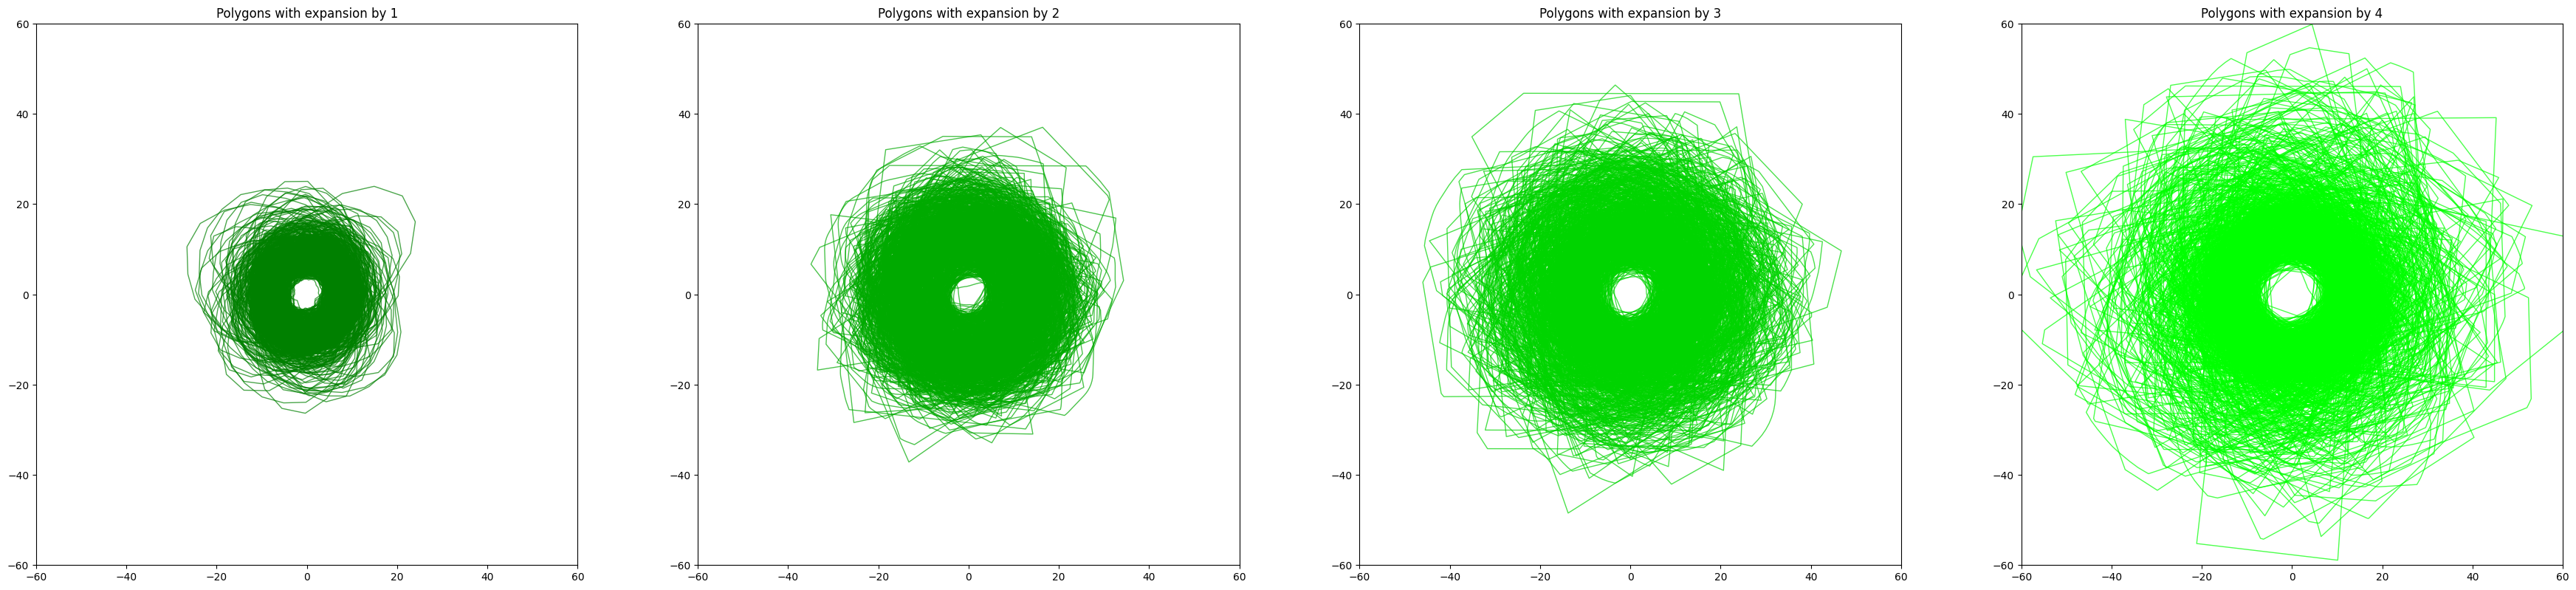

In [14]:

fig, axs = plt.subplots(1, len(crop_polygons_demean), figsize=(9 * len(crop_polygons_demean), 8))

if len(crop_polygons_demean) == 1:
    axs = [axs]  # ensure axs is iterable

for ax, (i, data) in zip(axs, crop_polygons_demean.items()):
    plot_polygons(
        data['polygons_dem'],
        ax=ax,
        facecolor=(0, 0, 0, 0),
        edgecolor=(0, 0.5 + 0.5 * i / (len(crop_polygons_demean) - 1), 0, 0.7),
        linewidth=1,
    )
    ax.set_aspect("equal")
    ax.set_title(f"Polygons with expansion by {i + 1}")
    ax.set_xlim(-60, 60)
    ax.set_ylim(-60, 60)
plt.tight_layout()
plt.show()


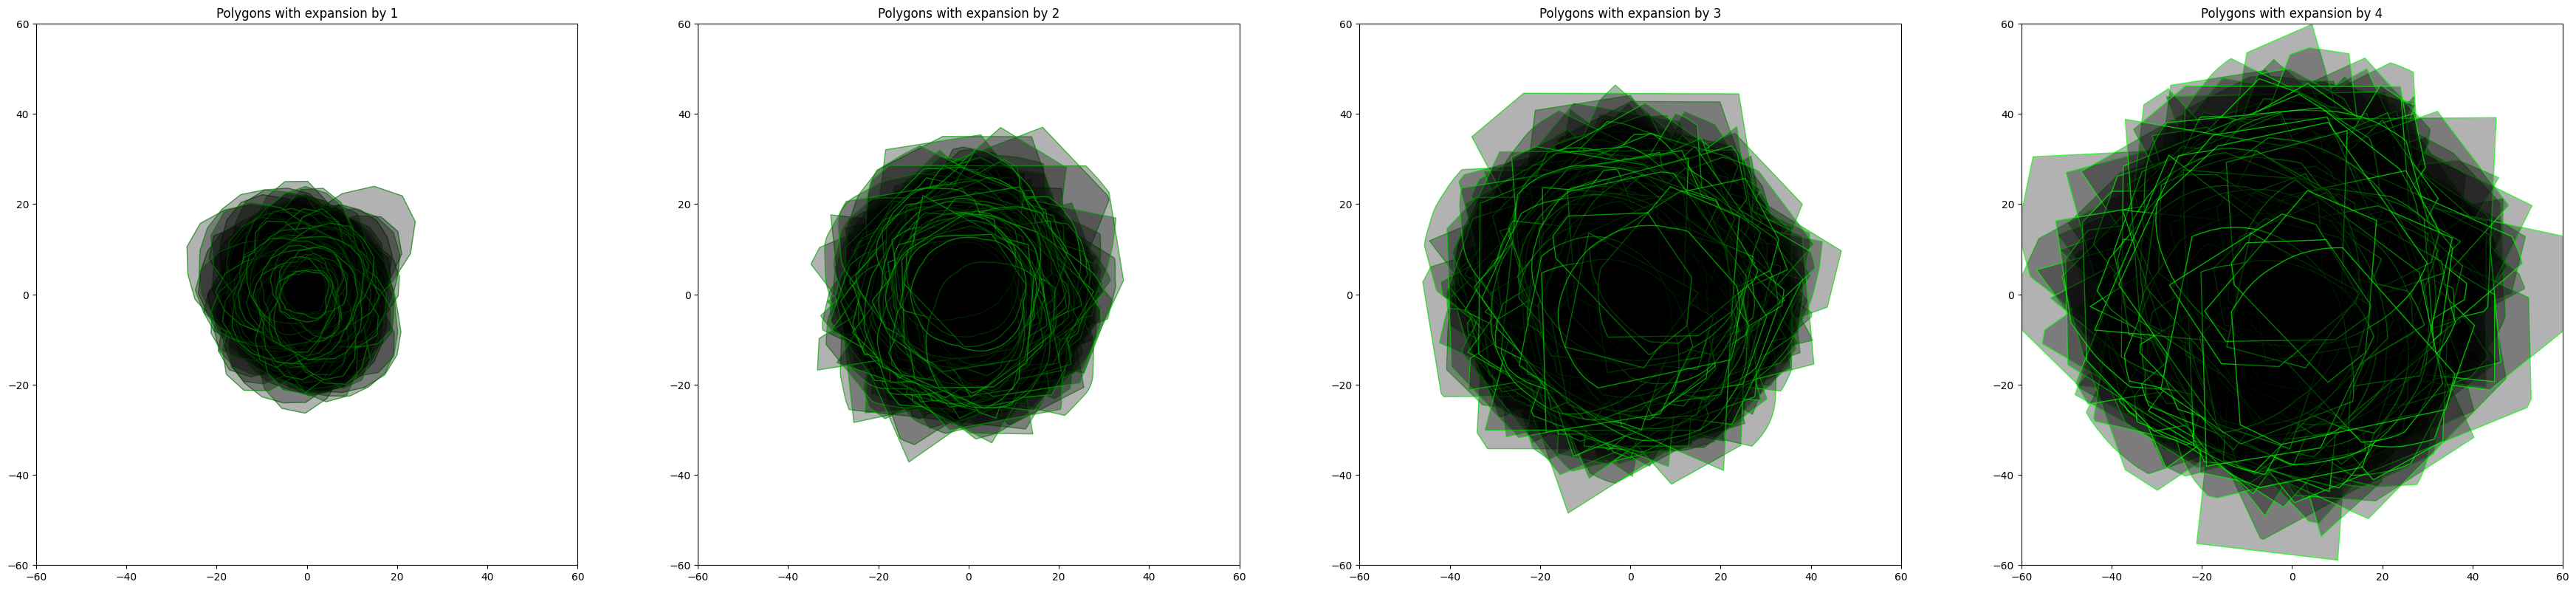

In [15]:

fig, axs = plt.subplots(1, len(crop_polygons_demean), figsize=(9 * len(crop_polygons_demean), 8))

if len(crop_polygons_demean) == 1:
    axs = [axs]  # ensure axs is iterable

for ax, (i, data) in zip(axs, crop_polygons_demean.items()):
    plot_polygons(
        data['polygons_dem'],
        ax=ax,
        facecolor=(0, 0, 0, 0.3),
        edgecolor=(0, 0.5 + 0.5 * i / (len(crop_polygons_demean) - 1), 0, 0.7),
        linewidth=1,
    )
    ax.set_aspect("equal")
    ax.set_title(f"Polygons with expansion by {i + 1}")
    ax.set_xlim(-60, 60)
    ax.set_ylim(-60, 60)
plt.tight_layout()
plt.show()

In [ ]:
crop_polygons = {}
for idx, data in cell_polygons.items():
    crop_polygons[idx] = {'polygons_dem':[
        shift_polygon(poly, x_min, y_min).reshape(-1, 2) for poly in data['polygons']
        if polygon_in_crop(poly, x_min, x_max, y_min, y_max)
    ]
    }


In [11]:
enact_polygons = {}
for idx, data in cell_polygons.items():
    enact_polygons[idx] = {
        "polygons": [poly.reshape(-1, 2) for poly in data["polygons"]],
        "areas": [Polygon(poly.reshape(-1, 2)).area for poly in data["polygons"]]
    }

/tmp/ipykernel_3252005/1015958568.py:24: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


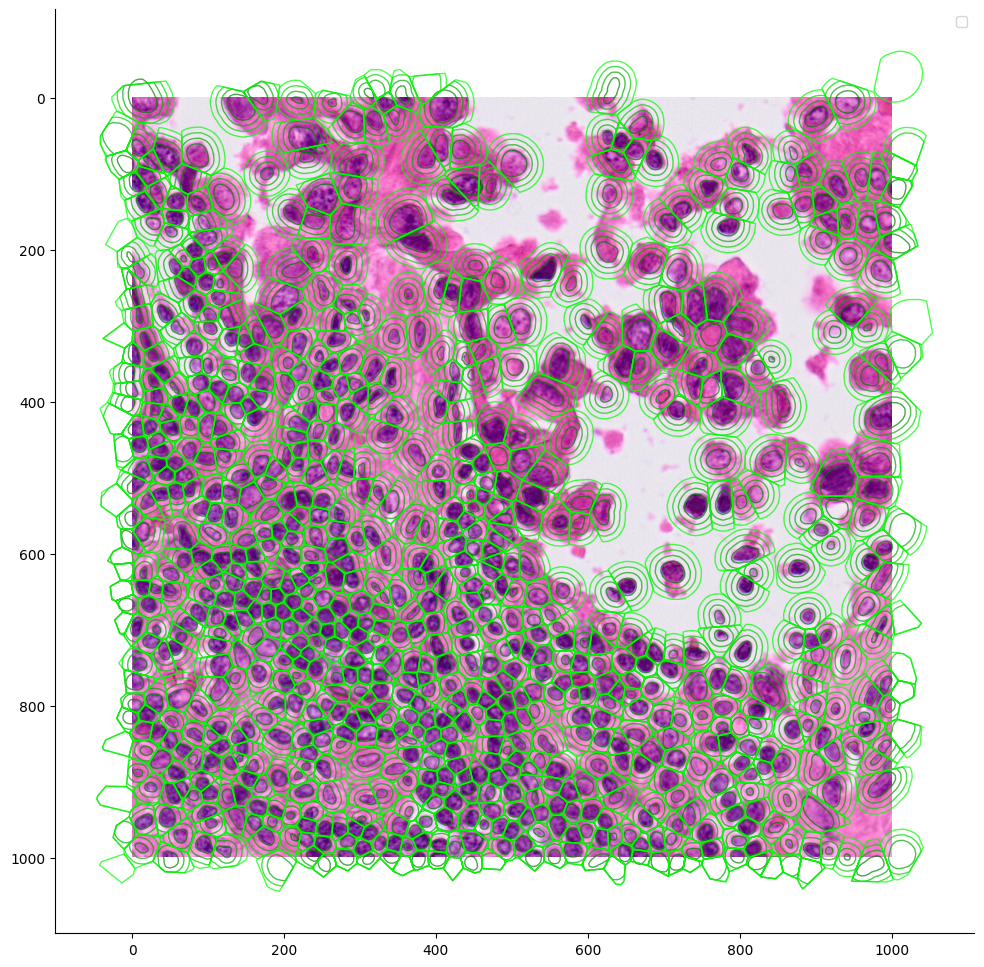

In [12]:
fig = plt.figure(figsize=(12, 12))
ax = plt.gca()

# Show zoomed region of the full resolution image
ax.imshow(wsi_image[y_min:y_max, x_min:x_max])

colors = plt.cm.tab10.colors  # Use tab10 colormap for up to 10 datasets

for i, (label, data) in enumerate(crop_polygons.items()):
    plot_polygons(
        data['polygons_dem'],
        ax=ax,
        facecolor=(0, 0, 0, 0),
        edgecolor=(0, 0.5 + 0.5 * i / (len(crop_polygons_demean) - 1), 0, 0.7),
        linewidth=1,
        label=f"Dataset {label}"
    )

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
ax.set_aspect("equal", adjustable="box")
ax.legend()


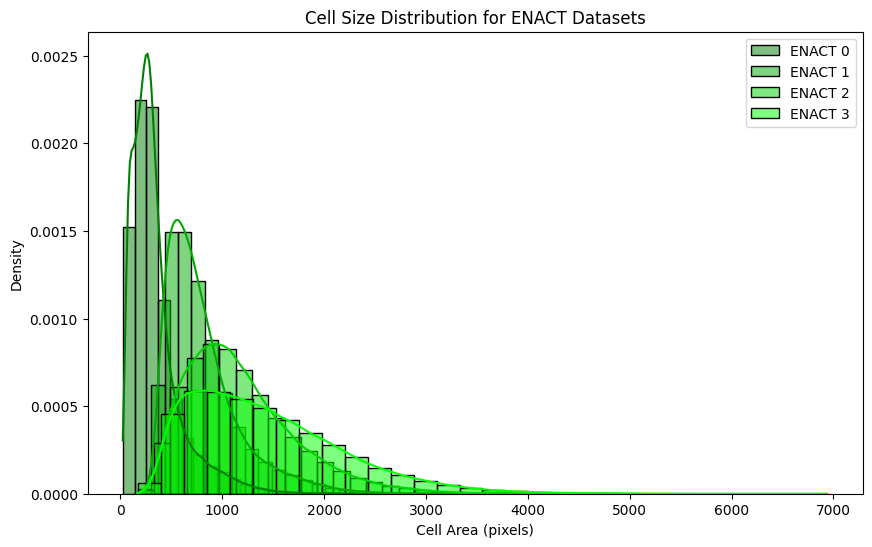

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 6))
for idx, data in enact_polygons.items():
    color = (0, 0.5 + 0.5 * idx / (len(crop_polygons_demean) - 1), 0, 0.7)
    sns.histplot(
        data['areas'],
        label=f"Nucleus +{idx}",
        kde=True,
        stat="density",
        bins=30,
        alpha=0.5,
        color=color
    )
plt.xlabel("Cell Area (pixels)")
plt.ylabel("Density")
plt.title("Cell Size Distribution for expanded Stardist Segmentations")
plt.legend()
plt.show()